In [1]:
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
info = pynvml.nvmlDeviceGetMemoryInfo(handle)
print(f'Total memory: {info.total / 1024**3:.2f} GB')
print(f'Free memory: {info.free / 1024**3:.2f} GB')
print(f'Used memory: {info.used / 1024**3:.2f} GB')
import dask_cudf
import cupy as cp
import rmm
import cudf
import gc
import cudf.pandas
cudf.pandas.install()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Total memory: 8.00 GB
Free memory: 7.37 GB
Used memory: 0.63 GB


In [2]:
l_o_business= dask_cudf.read_csv('Legally_Operating_Businesses_20240527.csv', blocksize="100MB")


In [3]:
l_o_business.columns

Index(['DCA License Number', 'License Type', 'License Expiration Date',
       'License Status', 'License Creation Date', 'Industry', 'Business Name',
       'Business Name 2', 'Address Building', 'Address Street Name',
       'Secondary Address Street Name', 'Address City', 'Address State',
       'Address ZIP', 'Contact Phone Number', 'Address Borough',
       'Borough Code', 'Community Board', 'Council District', 'BIN', 'BBL',
       'NTA', 'Census Tract', 'Detail', 'Longitude', 'Latitude', 'Location'],
      dtype='object')

In [4]:
l_o_business = l_o_business[["DCA License Number","License Type","License Expiration Date","License Creation Date","Industry","Business Name","Address Building","Address ZIP","Address Borough","BIN","Latitude","Longitude"]]

In [5]:
for column in l_o_business.columns:
    print(f"Value counts for {column}:")
    value_counts = l_o_business[column].value_counts().compute()
    print(value_counts)
    print("\n")
    # print(f"Unique values for {column}:")
    
    # Replace null values with a placeholder or drop them
    # taxi_busyness_data[column] = taxi_busyness_data[column].fillna(-1)  # Adjust based on data type and context
    # print("hi")
    
    # unique_values = taxi_busyness_data[column].unique_count()
    # print(unique_values)
    # print("\n")

print(l_o_business.nunique().compute())
info = pynvml.nvmlDeviceGetMemoryInfo(handle)

print(f'Used memory: {info.used / 1024**3:.2f} GB')
gc.collect()

Value counts for DCA License Number:
DCA License Number
1374839-DCA    2
2003600-DCA    2
0000711-DCA    1
0002902-DCA    1
0006164-DCA    1
              ..
2115285-DCA    1
2115286-DCA    1
2115287-DCA    1
2115288-DCA    1
2115289-DCA    1
Name: count, Length: 281411, dtype: int64


Value counts for License Type:
License Type
Business      186949
Individual     94464
Name: count, dtype: int64


Value counts for License Expiration Date:
License Expiration Date
02/28/2025    12320
02/28/2015     6717
02/28/2017     6512
02/28/2019     6096
12/31/2017     5814
              ...  
12/30/2014        1
12/30/2018        1
12/30/2019        1
12/30/2021        1
12/31/1988        1
Name: count, Length: 2840, dtype: int64


Value counts for License Creation Date:
License Creation Date
12/05/2000    365
02/23/2018    293
12/06/2000    281
01/05/2001    224
12/30/2002    207
             ... 
12/28/2008      1
12/30/1991      1
12/31/1985      1
12/31/1995      1
12/31/2005      1
Name: count

324

In [6]:
rows = l_o_business.shape[0].compute()
print(rows)

281413


In [7]:
null_counts = l_o_business.isnull().sum()
print(null_counts.compute())

DCA License Number              0
License Type                    0
License Expiration Date     21084
License Creation Date           0
Industry                        0
Business Name                  53
Address Building            95554
Address ZIP                   871
Address Borough             96010
BIN                        117145
Latitude                   104881
Longitude                  104881
dtype: int64


In [8]:
for column in l_o_business.columns:
    non_null_count = l_o_business[column].dropna().shape[0].compute()
    print(f"Non-null count for column {column}: {rows - non_null_count}")


Non-null count for column DCA License Number: 0
Non-null count for column License Type: 0
Non-null count for column License Expiration Date: 21084
Non-null count for column License Creation Date: 0
Non-null count for column Industry: 0
Non-null count for column Business Name: 53
Non-null count for column Address Building: 95554
Non-null count for column Address ZIP: 871
Non-null count for column Address Borough: 96010
Non-null count for column BIN: 117145
Non-null count for column Latitude: 104881
Non-null count for column Longitude: 104881


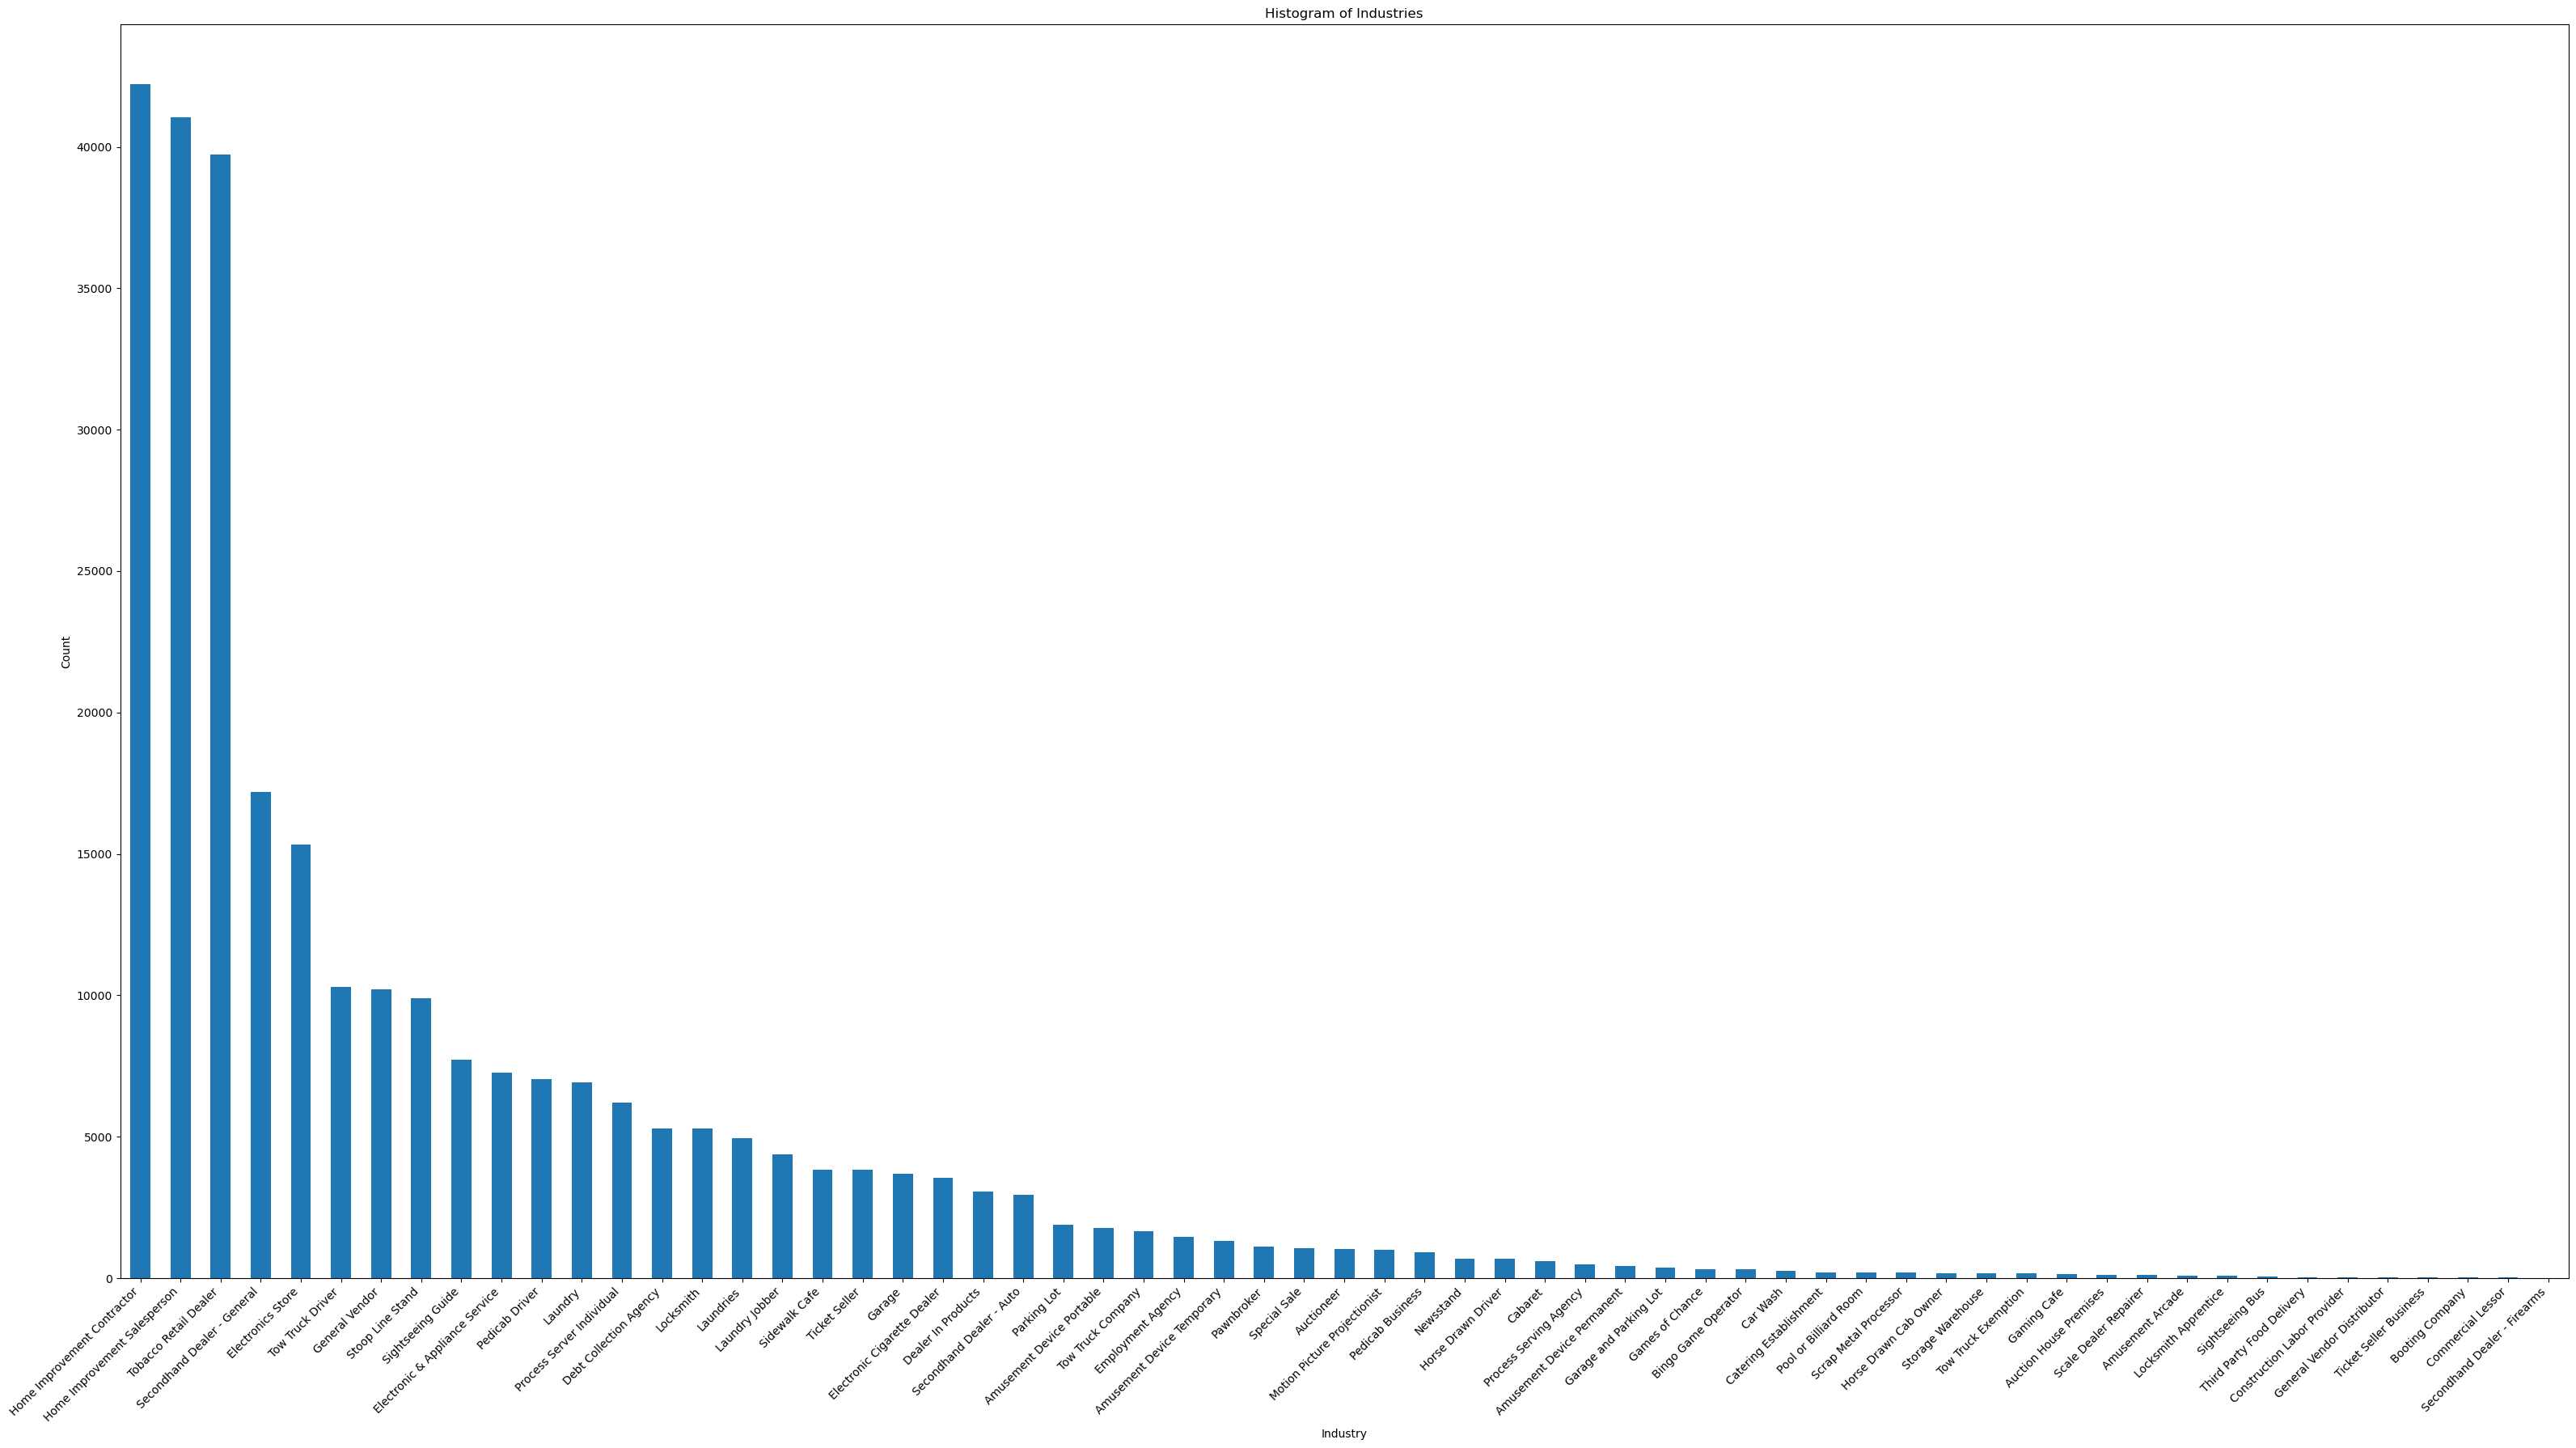

In [9]:
industry_counts = l_o_business['Industry'].value_counts().compute()

# Convert the computed series to pandas for easy plotting
industry_counts = industry_counts.to_pandas()

# Plot the histogram
ax = industry_counts.plot(kind='bar', figsize=(32, 18))
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.set_title('Histogram of Industries')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [10]:
no_expiration_date_rows = l_o_business[l_o_business['License Expiration Date'].isnull()]

# Compute the filtered DataFrame to bring it into memory
no_expiration_date_rows_computed = no_expiration_date_rows.compute()

# Display the filtered rows
print(no_expiration_date_rows_computed.head())

    DCA License Number License Type License Expiration Date  \
17         2080839-DCA   Individual                    <NA>   
25         2016468-DCA   Individual                    <NA>   
55         2042978-DCA   Individual                    <NA>   
125        1212608-DCA   Individual                    <NA>   
231        2048700-DCA   Individual                    <NA>   

    License Creation Date                      Industry        Business Name  \
17             12/19/2018  Home Improvement Salesperson  FILIPCHENKO, VITALY   
25             12/15/2014  Home Improvement Salesperson                 <NA>   
55             08/26/2016  Home Improvement Salesperson       MATUTE, BLANCA   
125            10/17/2005  Home Improvement Salesperson        MINDLIN, GARY   
231            02/23/2017  Home Improvement Salesperson                 <NA>   

    Address Building Address ZIP Address Borough   BIN Latitude Longitude  
17              <NA>       10010            <NA>  <NA>     <NA> 

In [11]:
unique_l_o_business = l_o_business.drop_duplicates(subset=['DCA License Number'], keep='first')

In [12]:
na_lat_long_rows = l_o_business[l_o_business['Latitude'].isnull() & l_o_business['Longitude'].isnull()]

na_lat_long_zip = na_lat_long_rows['Address ZIP']

na_lat_long_zip_computed = na_lat_long_zip.compute()

na_lat_long_zip_dropped = na_lat_long_zip_computed.dropna()

null_count = na_lat_long_zip.isnull().sum().compute()
print(null_count)

print(na_lat_long_zip_computed)

825
0         07726
1         11214
2         10028
3         V6Z1C
4         19013
          ...  
281336    11040
281338    11231
281340    11793
281365    10038
281377    10312
Name: Address ZIP, Length: 104881, dtype: object


In [13]:
na_lat_long_zip_dropped = pd.Series(na_lat_long_zip_dropped)
na_lat_long_zip_dropped = na_lat_long_zip_dropped.astype(str)

# Strip leading and trailing whitespace from each string in the DataFrame

zip_code_counts = na_lat_long_zip_dropped.value_counts()


In [14]:
print(zip_code_counts.dtype)
zip_code_counts

int64


Address ZIP
11214    1236
11235    1172
10314    1131
11230     992
11229     958
         ... 
NIR 7       1
ONL4N       1
SW1Y        1
TW91A       1
V6Z1C       1
Name: count, Length: 3590, dtype: int64

In [15]:
top_zip_codes = zip_code_counts.head(10)
print(top_zip_codes)

Address ZIP
11214    1236
11235    1172
10314    1131
11230     992
11229     958
11234     957
11385     945
11218     922
11223     838
11377     767
Name: count, dtype: int64


TypeError: float() argument must be a string or a real number, not 'NAType'

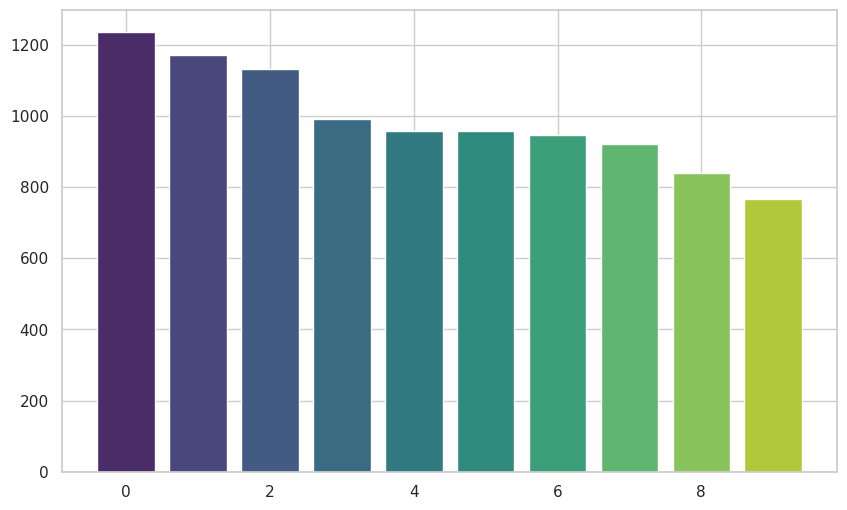

In [16]:
top_zip_codes = zip_code_counts.head(10)

# Convert the Series to a DataFrame for plotting
top_zip_codes_df = top_zip_codes.reset_index()
top_zip_codes_df.columns = ['ZIP Code', 'Frequency']

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ZIP Code', y='Frequency', data=top_zip_codes_df, palette="viridis")
ax.set_title('Top 10 ZIP Codes with Missing Latitude and Longitude')
ax.set_xlabel('ZIP Code')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
no_expiration_date_rows = l_o_business[l_o_business['License Expiration Date'].isnull()]

# Compute the filtered DataFrame to bring it into memory
no_expiration_date_rows_computed = no_expiration_date_rows.compute()

# Display the filtered rows
print(no_expiration_date_rows_computed.head())

    DCA License Number License Type License Expiration Date  \
17         2080839-DCA   Individual                    <NA>   
25         2016468-DCA   Individual                    <NA>   
55         2042978-DCA   Individual                    <NA>   
125        1212608-DCA   Individual                    <NA>   
231        2048700-DCA   Individual                    <NA>   

    License Creation Date                      Industry        Business Name  \
17             12/19/2018  Home Improvement Salesperson  FILIPCHENKO, VITALY   
25             12/15/2014  Home Improvement Salesperson                 <NA>   
55             08/26/2016  Home Improvement Salesperson       MATUTE, BLANCA   
125            10/17/2005  Home Improvement Salesperson        MINDLIN, GARY   
231            02/23/2017  Home Improvement Salesperson                 <NA>   

    Address Building Address ZIP Address Borough   BIN Latitude Longitude  
17              <NA>       10010            <NA>  <NA>     <NA> 

In [ ]:
filtered_l_o_business = l_o_business.dropna(subset=["Latitude", "Longitude", "Address ZIP"])

In [ ]:
l_o_business.to_csv('saved_csvs/legally_operating_business.csv', single_file=True)

['/home/eamonn-walsh/Documents/Summer-Project/saved_csvs/legally_operating_business.csv']